pip install prophet


Step 1:importing nessaccary libraires and loading the dataset

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('SN_d_tot_V2.0.csv', delimiter=';', header=None, names=['time', 'sunspots', 'std', 'obs', 'def'])

# Function to convert fractional year to datetime (monthly granularity)
def fractional_year_to_date(year):
    """
    Converts fractional years (e.g., 1749.042) into a datetime object.
    Args:
        year (float): The year in fractional format.
    Returns:
        datetime: A datetime object corresponding to the fractional year.
    """
    year_int = int(year)  # Extract the integer part of the year
    fraction = year - year_int  # Extract the fractional part
    month = int(fraction * 12) + 1  # Convert fraction to a month (1-based index)
    return datetime(year_int, month, 1)

# Convert fractional year to datetime
df['ds'] = df['time'].apply(fractional_year_to_date)
df['y'] = df['sunspots']

# Keep only necessary columns for Prophet
df = df[['ds', 'y']]

# Check the processed dataframe
print(df.head())

# Time unit detection for monthly data
time_unit = 'date'
future_periods = [100, 200, 365]
print(f"\n Detected time unit: {time_unit}")




FileNotFoundError: [Errno 2] No such file or directory: 'SN_d_tot_V2.0.csv'

Step2:

In [ ]:
# Function to train and forecast
def train_and_forecast(df, periods, growth='linear', seasonality_mode='additive', n_changepoints=25, changepoint_prior_scale=0.05):
    model = Prophet(growth=growth, seasonality_mode=seasonality_mode, n_changepoints=n_changepoints, changepoint_prior_scale=changepoint_prior_scale)
    model.add_seasonality(name='custom', period=365.25, fourier_order=5)
    model.fit(df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return model, forecast

# Function to evaluate model
def evaluate_model(model, df):
    cv_results = cross_validation(model, initial='730 days', period='365 days', horizon='365 days')
    cv_metrics = performance_metrics(cv_results)
    
    y_true = df['y'].values
    y_pred = model.predict(df[['ds']])['yhat'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mae, mape, r2, cv_metrics

In [ ]:
# Train and forecast for different periods
for period in future_periods:
    print(f"\nForecasting for {period} {time_unit}s into the future:")
    
    model, forecast = train_and_forecast(df, period)
    
    # Print predicted values
    print("\nPredicted values:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(period))
    
    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['ds'], df['y'], label='Historical Data')
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, color='red')
    ax.set_title(f'Sunspot Forecast for {period} {time_unit}s')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Sunspots')
    ax.legend()
    plt.show()

Step3: (a)

In [2]:
# Suppress cmdstanpy logs (optional)
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Example data setup (replace with your dataset)
data = pd.DataFrame({
    'ds': pd.date_range(start='2000-01-01', periods=100, freq='YE'),  # Use 'YE' instead of 'Y'
    'y': [i + (i * 0.1) for i in range(100)]  # Simulated linear growth
})




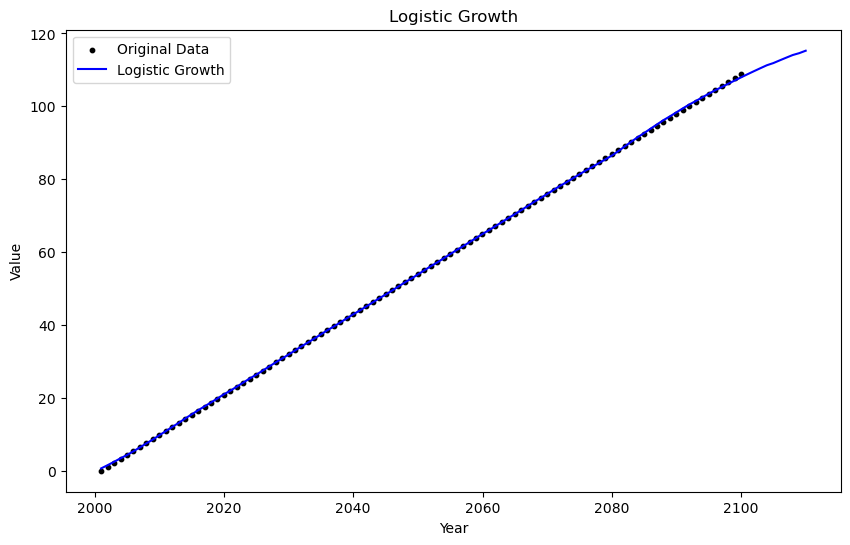

In [14]:
# Logistic Growth
data['cap'] = 150  # Example upper limit for logistic growth
model_logistic = Prophet(growth='logistic')
model_logistic.fit(data)

future_logistic = model_logistic.make_future_dataframe(periods=10, freq='YE')  # Use 'YE'
future_logistic['cap'] = 150
forecast_logistic = model_logistic.predict(future_logistic)


plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], data['y'], label='Original Data', color='black', s=10)
plt.plot(forecast_logistic['ds'], forecast_logistic['yhat'], label='Logistic Growth', color='blue')
plt.title("Logistic Growth")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()

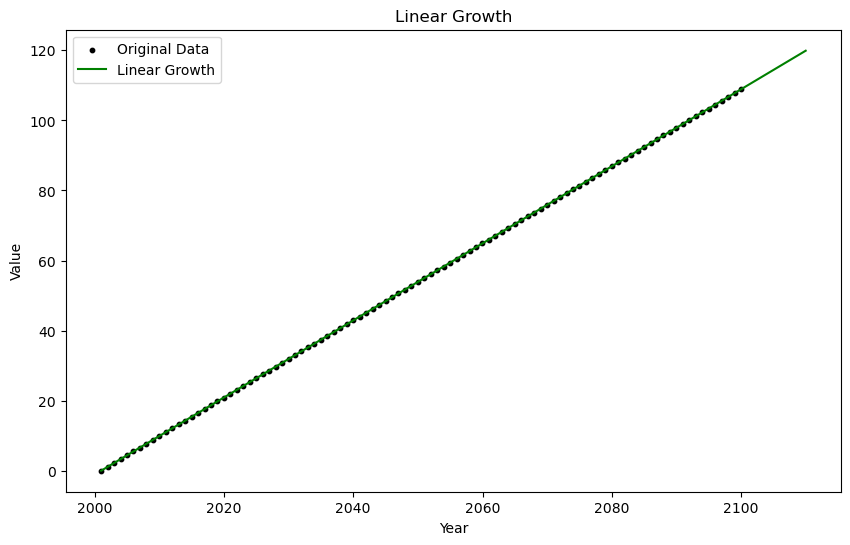

In [15]:
# Linear Growth
model_linear = Prophet()  # Default is linear
model_linear.fit(data)

future_linear = model_linear.make_future_dataframe(periods=10, freq='YE')  # Use 'YE'
forecast_linear = model_linear.predict(future_linear)

plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], data['y'], label='Original Data', color='black', s=10)
plt.plot(forecast_linear['ds'], forecast_linear['yhat'], label='Linear Growth', color='green')
plt.title("Linear Growth")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()


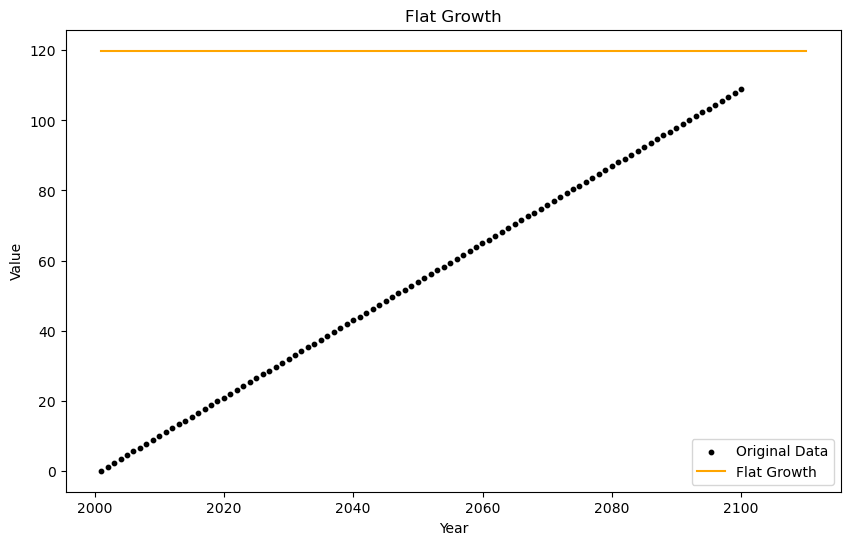

In [9]:
# Flat Growth (constant yhat beyond known data)
model_flat = Prophet()
model_flat.fit(data)

future_flat = model_flat.make_future_dataframe(periods=10, freq='YE')  # Use 'YE'
forecast_flat = model_flat.predict(future_flat)
forecast_flat['yhat'] = forecast_flat['yhat'].iloc[-1]  # Keep constant

plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], data['y'], label='Original Data', color='black', s=10)
plt.plot(forecast_flat['ds'], forecast_flat['yhat'], label='Flat Growth', color='orange')
plt.title("Flat Growth")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()

(b)

Testing monthly_simple...


00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:33 - cmdstanpy - INFO - Chain [1] done processing


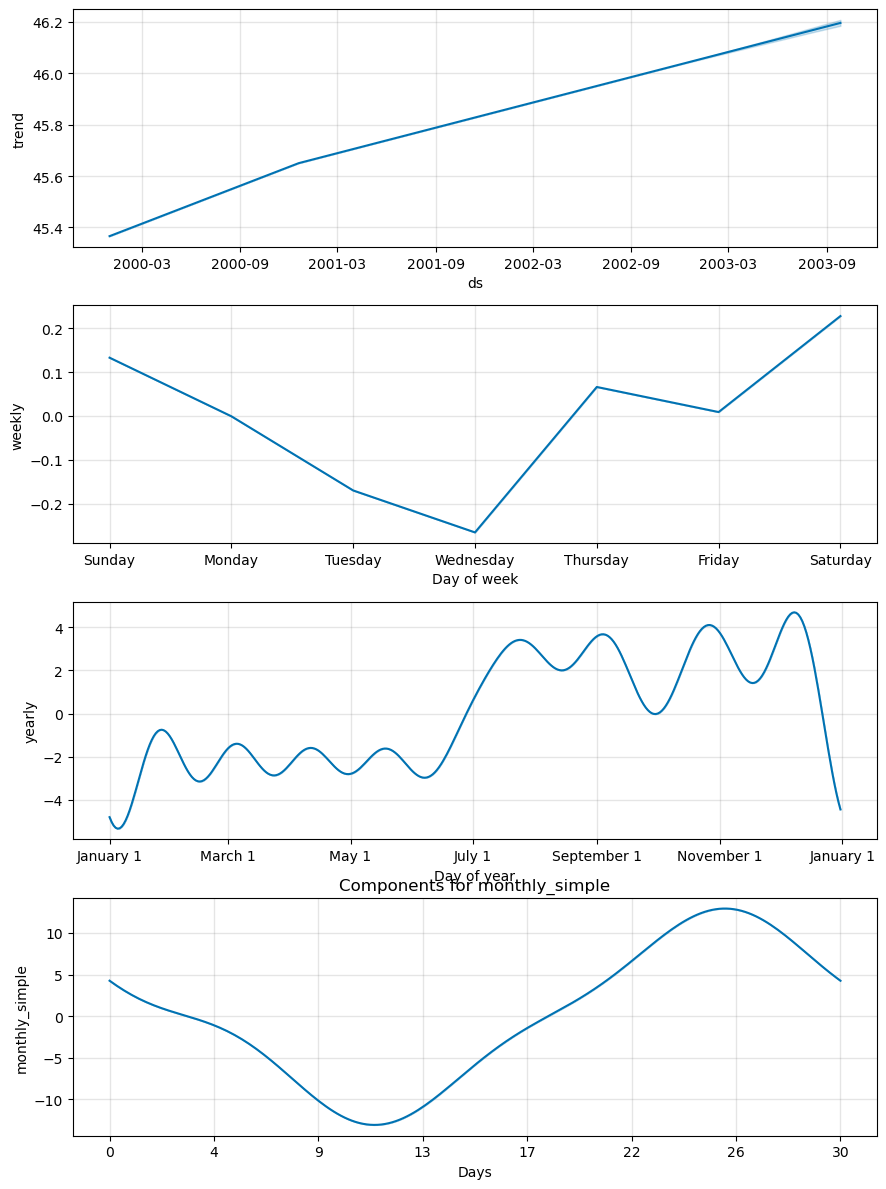

Testing monthly_complex...


00:15:36 - cmdstanpy - INFO - Chain [1] start processing
00:15:36 - cmdstanpy - INFO - Chain [1] done processing


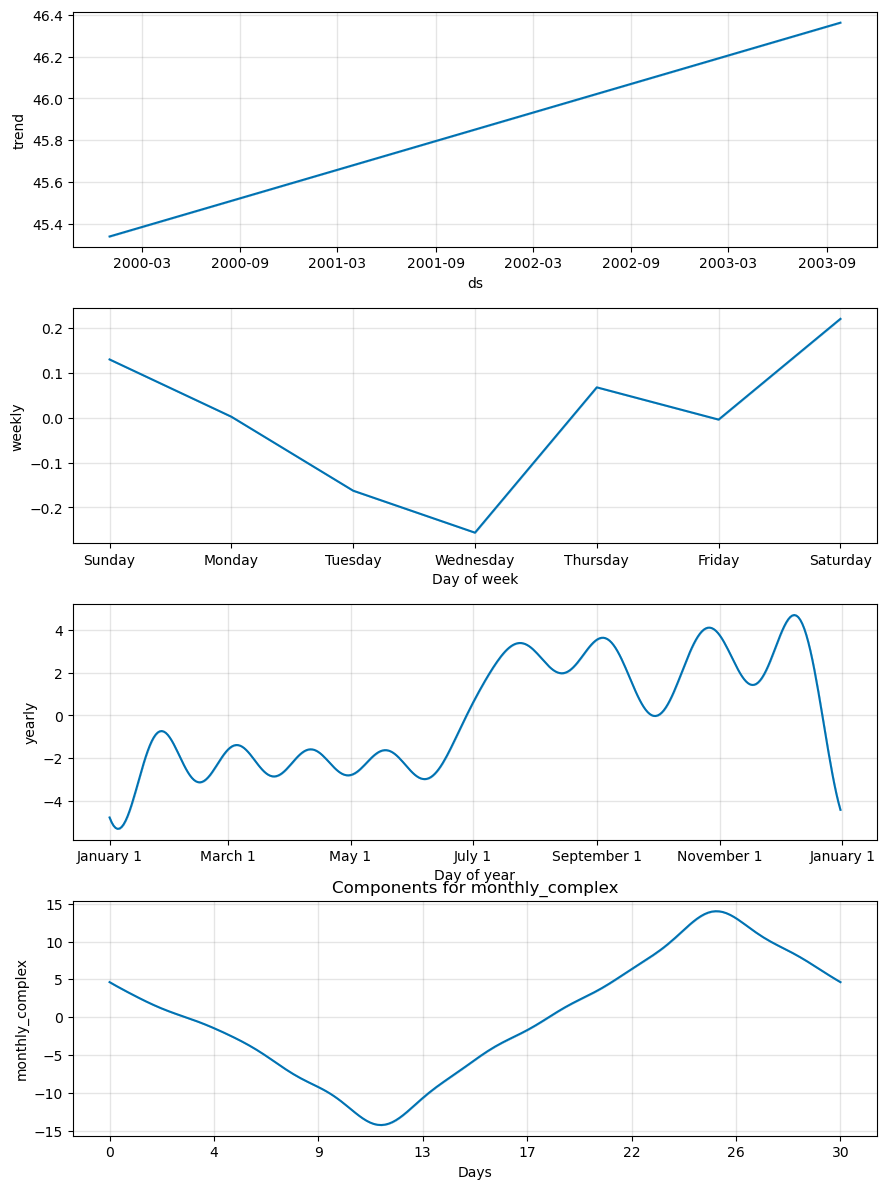

Testing quarterly...


00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:39 - cmdstanpy - INFO - Chain [1] done processing


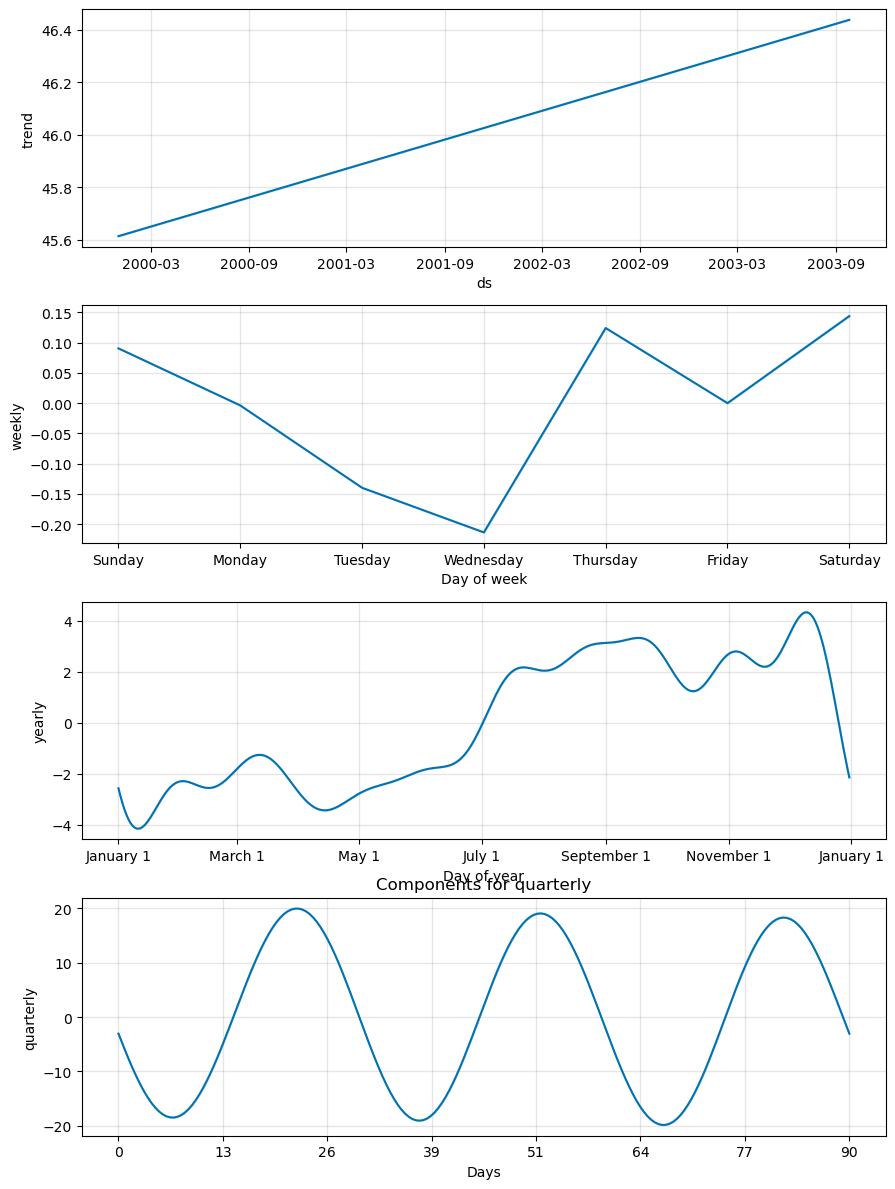

00:15:41 - cmdstanpy - INFO - Chain [1] start processing


Testing weekly...


00:15:42 - cmdstanpy - INFO - Chain [1] done processing


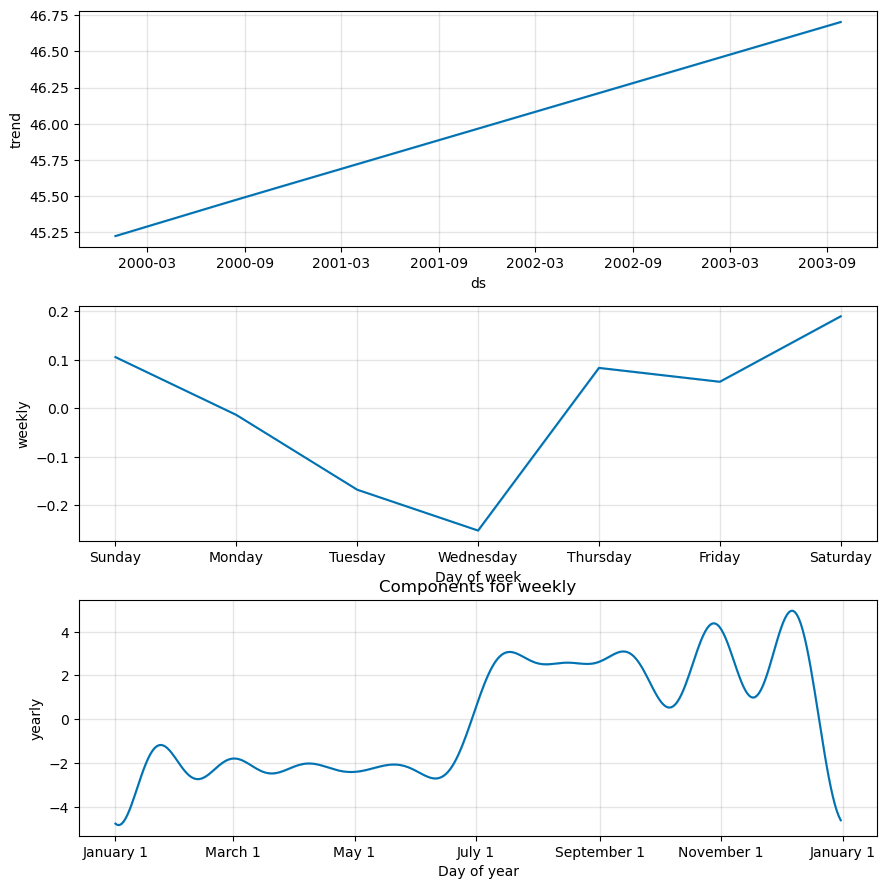

In [2]:
# Test different period and fourier_order combinations
test_cases = [
    {'name': 'monthly_simple', 'period': 30.5, 'fourier_order': 3},
    {'name': 'monthly_complex', 'period': 30.5, 'fourier_order': 10},
    {'name': 'quarterly', 'period': 90, 'fourier_order': 5},
    {'name': 'weekly', 'period': 7, 'fourier_order': 3},
]

for case in test_cases:
    print(f"Testing {case['name']}...")
    model = Prophet()
    model.add_seasonality(name=case['name'], period=case['period'], fourier_order=case['fourier_order'])
    model.fit(data)
    
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    
    model.plot_components(forecast)
    plt.title(f"Components for {case['name']}")
    plt.show()


(c)

Testing n_changepoints=5, changepoint_prior_scale=0.01...


23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing


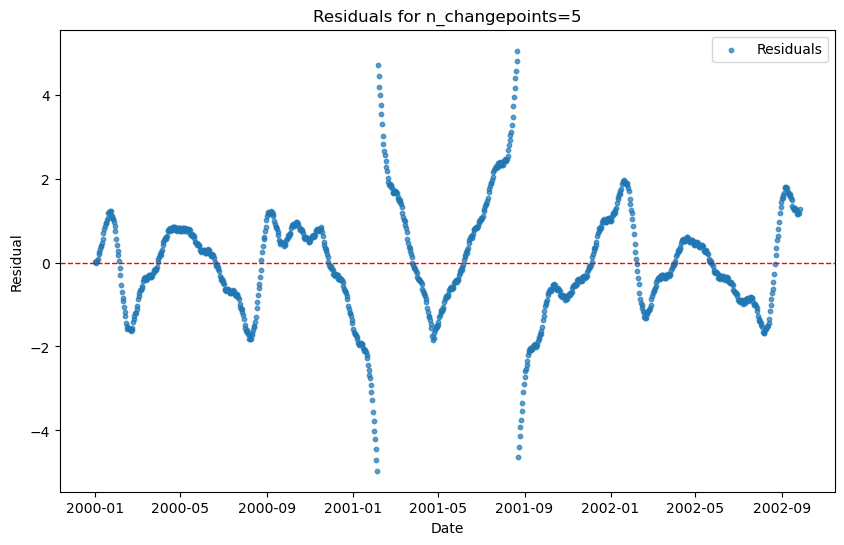

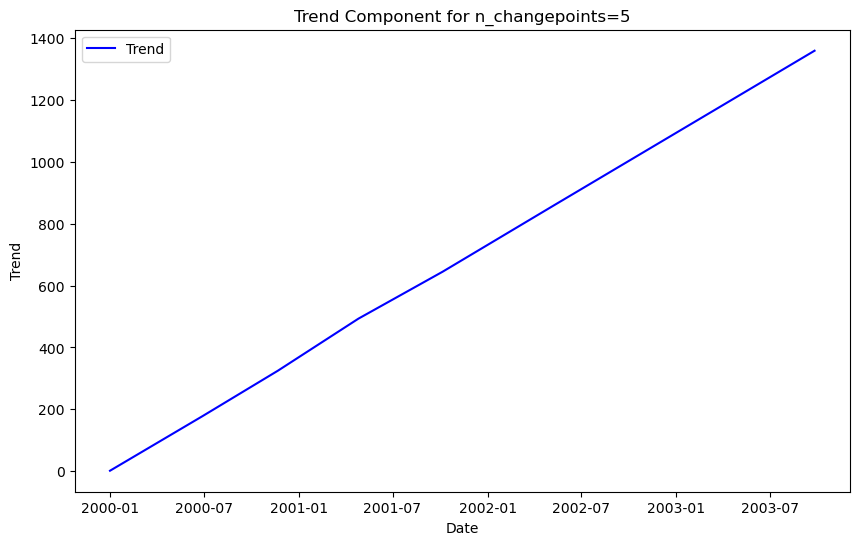

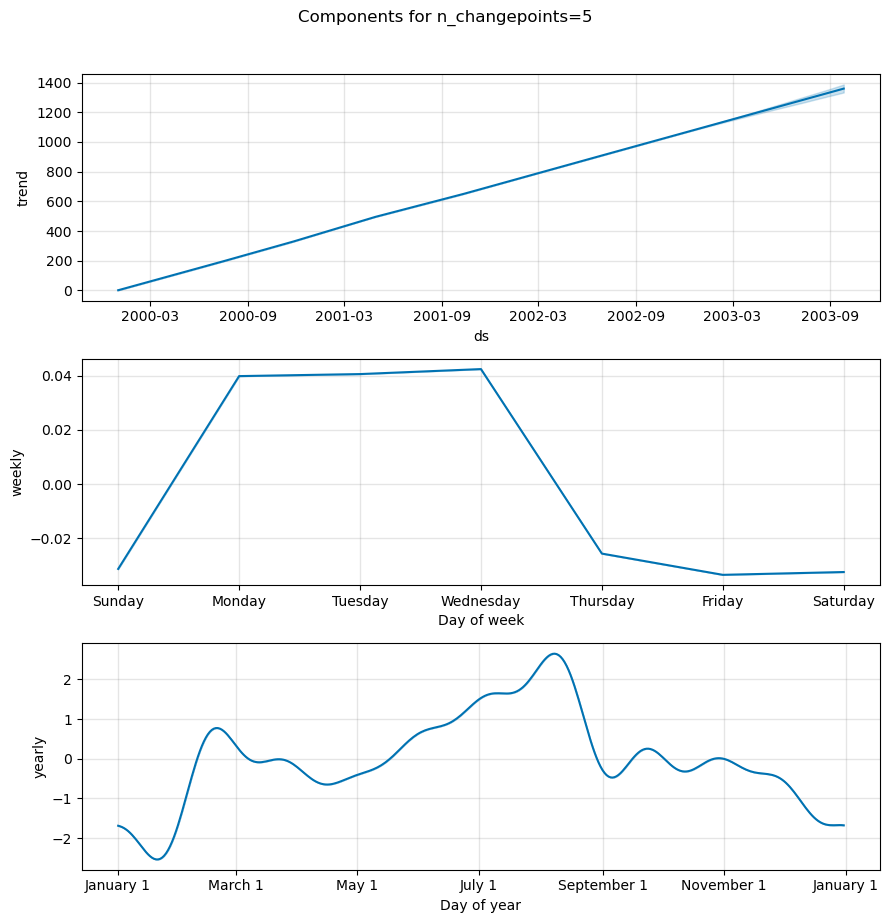

Testing n_changepoints=10, changepoint_prior_scale=0.1...


23:41:01 - cmdstanpy - INFO - Chain [1] start processing
23:41:02 - cmdstanpy - INFO - Chain [1] done processing


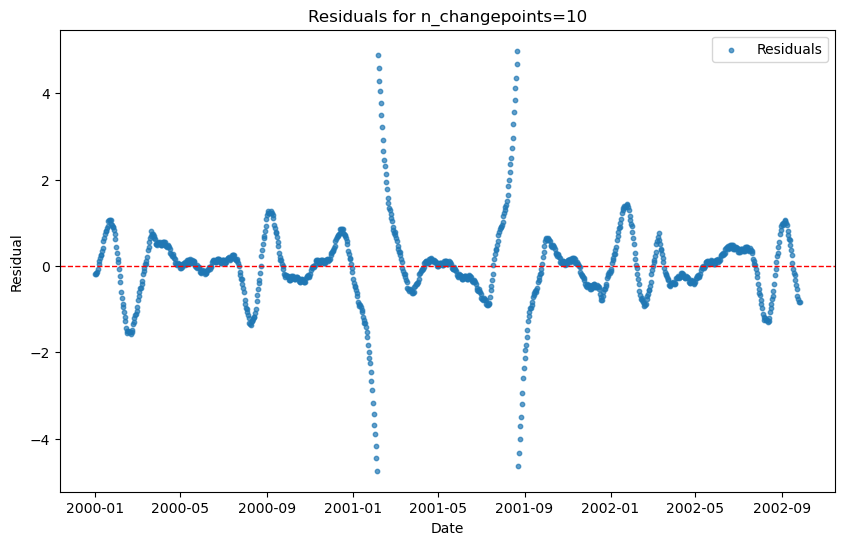

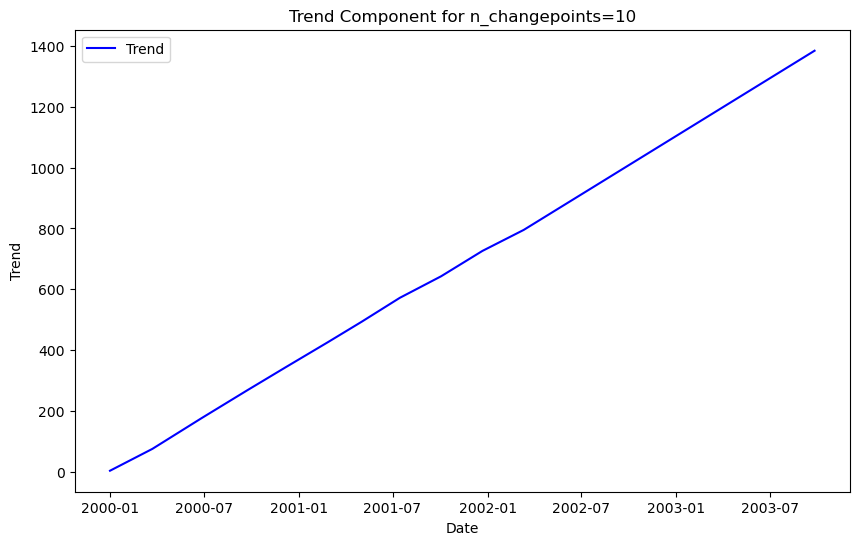

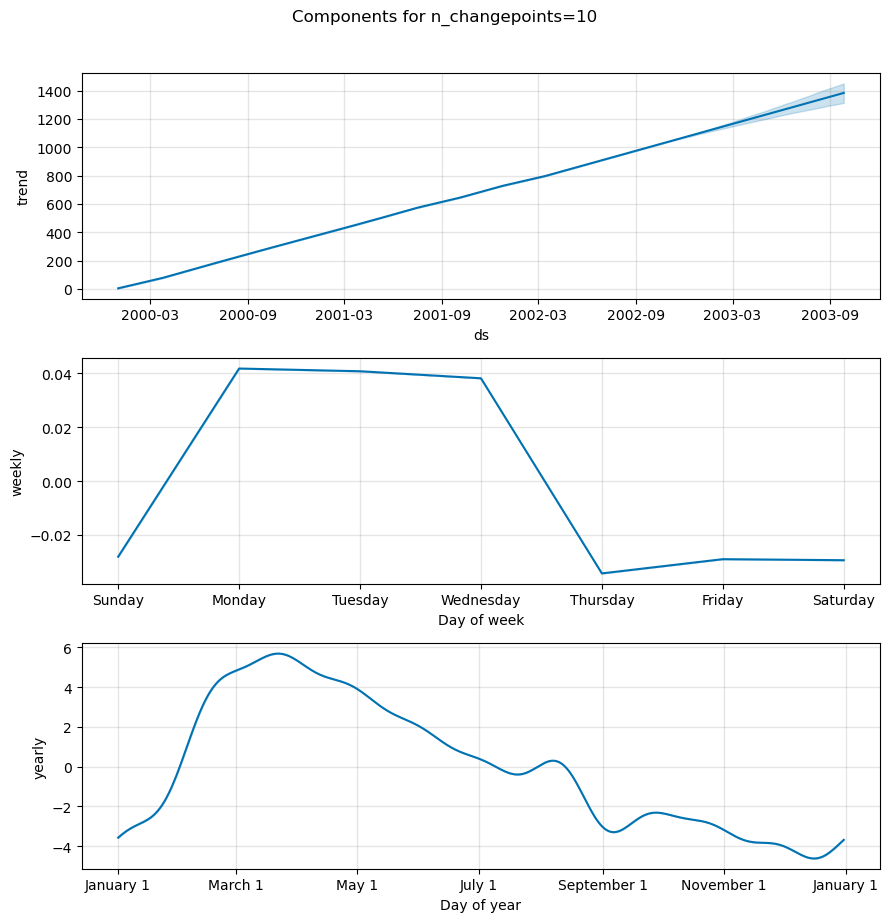

Testing n_changepoints=25, changepoint_prior_scale=0.5...


23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:07 - cmdstanpy - INFO - Chain [1] done processing


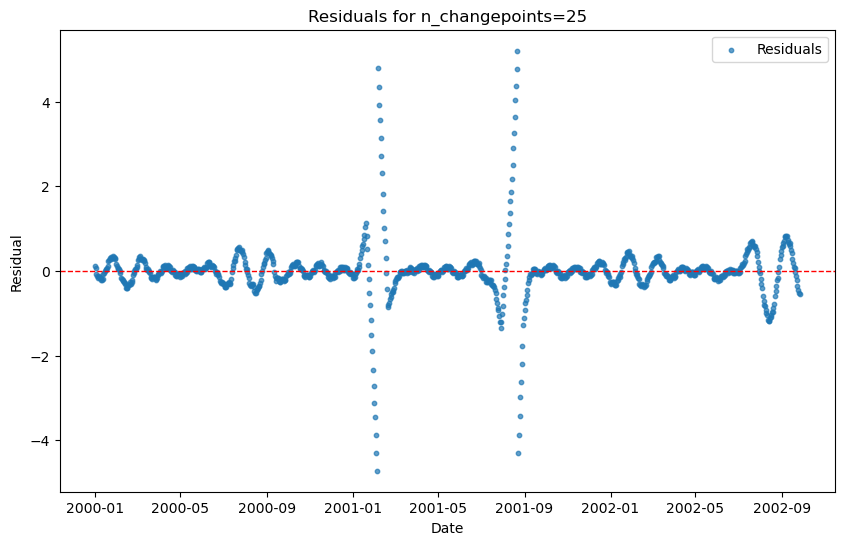

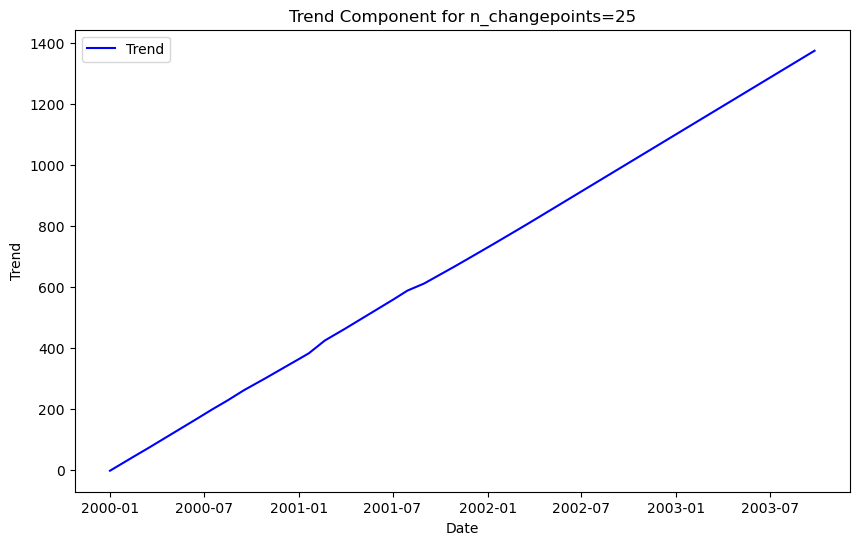

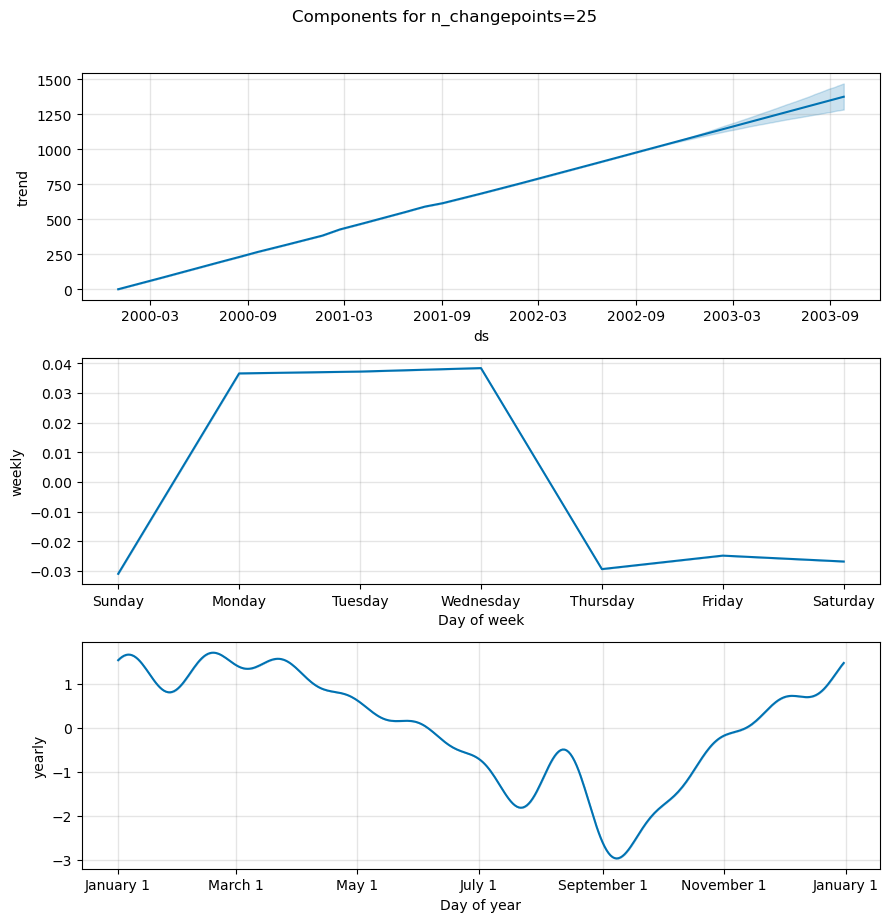

In [9]:
# Example data setup (replace with your dataset)
data = pd.DataFrame({
    'ds': pd.date_range(start='2000-01-01', periods=1000, freq='D'),
    'y': [i + (10 if 400 < i < 600 else 0) for i in range(1000)]  # Simulated trend change
})

# Define different tuning scenarios
test_cases = [
    {'n_changepoints': 5, 'changepoint_prior_scale': 0.01},
    {'n_changepoints': 10, 'changepoint_prior_scale': 0.1},
    {'n_changepoints': 25, 'changepoint_prior_scale': 0.5},
]

for case in test_cases:
    print(f"Testing n_changepoints={case['n_changepoints']}, changepoint_prior_scale={case['changepoint_prior_scale']}...")
    
    # Initialize the model with specified parameters
    model = Prophet(
        n_changepoints=case['n_changepoints'],
        changepoint_prior_scale=case['changepoint_prior_scale']
    )
    
    # Fit the model
    model.fit(data)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    
    # Plot Residuals
    plt.figure(figsize=(10, 6))
    residuals = data['y'] - forecast.loc[:len(data)-1, 'yhat']
    plt.scatter(data['ds'], residuals, s=10, alpha=0.7, label="Residuals")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Residuals for n_changepoints={case['n_changepoints']}")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.legend()
    plt.show()
    
    # Plot Trend Component
    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['trend'], color='blue', label='Trend')
    plt.title(f"Trend Component for n_changepoints={case['n_changepoints']}")
    plt.xlabel("Date")
    plt.ylabel("Trend")
    plt.legend()
    plt.show()
    
    # Plot Seasonality Components
    model.plot_components(forecast)
    plt.suptitle(f"Components for n_changepoints={case['n_changepoints']}", y=1.02)
    plt.tight_layout()
    plt.show()


In [6]:
# Define test cases with different changepoint and seasonality settings
test_cases = [
    {'n_changepoints': 5, 'changepoint_prior_scale': 0.01, 'seasonality': 'monthly'},
    {'n_changepoints': 10, 'changepoint_prior_scale': 0.1, 'seasonality': 'monthly'},
    {'n_changepoints': 25, 'changepoint_prior_scale': 0.5, 'seasonality': 'yearly'},
]

results = []

for case in test_cases:
    model = Prophet(
        n_changepoints=case['n_changepoints'],
        changepoint_prior_scale=case['changepoint_prior_scale']
    )
    
    # Add custom seasonality if applicable
    if case['seasonality'] == 'monthly':
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    elif case['seasonality'] == 'yearly':
        model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    
    # Train the model
    model.fit(train)
    
    # Make predictions
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    
    # Extract predictions for evaluation
    predicted = forecast.iloc[-365:]['yhat']
    actual = test['y']
    
    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    # Store results
    results.append({
        'n_changepoints': case['n_changepoints'],
        'changepoint_prior_scale': case['changepoint_prior_scale'],
        'seasonality': case['seasonality'],
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:38 - cmdstanpy - INFO - Chain [1] done processing
00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing


   n_changepoints  changepoint_prior_scale seasonality       MAE      MAPE  \
0               5                     0.01     monthly  4.191439  0.079379   
1              10                     0.10     monthly  3.870195  0.073313   
2              25                     0.50      yearly  0.076388  0.001426   

         R²  
0  0.267346  
1  0.374993  
2  0.999729  


Step4:

In [12]:
# Load the daily dataset
daily_data = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', periods=1000, freq='D'),
    'y': [10 + 0.05 * i + np.sin(2 * np.pi * i / 365) for i in range(1000)]  # Simulated daily data
})

# Split into train/test sets
train = daily_data.iloc[:-365]
test = daily_data.iloc[-365:]

# Train a Prophet model
model = Prophet()
model.fit(train)

# Make future predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Extract predicted values for the test set
predicted = forecast.iloc[-365:]['yhat']
actual = test['y']

# Evaluate using MAE, MAPE, and R2
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f"Model Evaluation for daily forecting:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.2f}")


23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:37 - cmdstanpy - INFO - Chain [1] done processing


Model Evaluation:
MAE: 3.80
MAPE: 7.20%
R²: 0.40
